In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft

In [2]:
seed = 1337
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 16

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.constellationDim	= 2
aeParam.constellationOrder	= chParam.M
aeParam.nLayers		= 2
aeParam.nHidden 	= 32
aeParam.activation  = tf.nn.selu
aeParam.dtype       = tf.float32

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 512*chParam.M # Increase for better results (especially if M>16)
trainingParam.batchSize 	= 32*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 20
trainingParam.path			= 'results_AWGN_noChannel'
trainingParam.filename		= 'M{}'.format(chParam.M)
trainingParam.saveWeights	= True
trainingParam.earlyStopping = 10
trainingParam.tx_iterations = 25
trainingParam.rx_iterations = 25
trainingParam.policy_sigma2 = 0.02

# TF constants
two = tf.constant(2,aeParam.dtype)
minusOne = tf.constant(-1,aeParam.dtype)
DIM = tf.constant(aeParam.constellationDim,aeParam.dtype)
PI = tf.constant(np.pi,aeParam.dtype)

In [3]:
# Channel Graph
sigma2_noise = tf.constant(0.1,aeParam.dtype)

channel_in = tf.placeholder( aeParam.dtype, shape=(None, aeParam.constellationDim) )
noise = tf.sqrt( sigma2_noise )\
            *tf.rsqrt(two)\
            *tf.random_normal(shape=tf.shape(channel_in),dtype=aeParam.dtype)

channel_out = channel_in + noise

In [4]:
# Tx Graph     
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.M) )
enc, enc_seed = ae.encoder(X, aeParam)

W0917 20:15:40.704045 140237100992320 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# enc = ae.encoder(X,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)
# enc_norm = cfh.IQ_norm( enc )

# Tx policy
policy_sigma2 = tf.placeholder( aeParam.dtype, shape=())
perturbation = tf.sqrt( policy_sigma2 ) * tf.rsqrt(two) * tf.random_normal(shape=tf.shape(enc),dtype=aeParam.dtype)
enc_pert = enc + perturbation

In [6]:
# Rx Graph
Y = tf.placeholder( aeParam.dtype, shape=(None, aeParam.constellationDim) )
dec = ae.decoder(Y,aeParam)
per_ex_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=X,logits=dec)

In [7]:
# Rx Loss
correct_prediction = tf.equal(tf.argmax(X,1), tf.argmax(dec,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, aeParam.dtype))
rx_loss = tf.reduce_mean(per_ex_loss)
rx_vars = [item for item in tf.global_variables() if 'decoder' in item.name]
rx_optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(rx_loss, var_list=rx_vars)

In [8]:
metricsDict = {'xentropy':rx_loss, 'accuracy_metric':accuracy}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

W0917 20:15:42.283854 140237100992320 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
# avg_loss, avg_loss_update, avg_loss_reset = cfh.create_reset_metric(tf.metrics.mean, 'loss_metric', rx_loss)
# avg_accuracy, avg_accuracy_update, avg_accuracy_reset = cfh.create_reset_metric(tf.metrics.mean, 'accuracy_metric', accuracy)

In [10]:
# Tx Loss
tx_perturbed = tf.placeholder( aeParam.dtype, shape=(None,aeParam.constellationDim) )
tx_per_ex_loss  = tf.placeholder( aeParam.dtype, shape=(None,) )
# batch_size = tf.constant(trainingParam.batchSize, aeParam.dtype)
batch_size = tf.placeholder( aeParam.dtype, shape=() )

policy = tf.log( tf.rsqrt( tf.pow(PI*policy_sigma2,DIM) ) * tf.exp( minusOne * tf.square(cfh.norm( tx_perturbed-enc )) / policy_sigma2 ) )
tx_vars = [item for item in tf.global_variables() if 'encoder' in item.name]

policy_gradient = tf.gradients(policy, tx_vars, grad_ys=tx_per_ex_loss/batch_size)

grads_and_vars = [ ( g,v ) for g,v in zip(policy_gradient,tx_vars)]
tx_optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).apply_gradients(grads_and_vars)

W0917 20:15:42.434755 140237100992320 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

In [12]:
def TrainReceiver():
    nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
    
    bestLoss = 10000
    
    for epoche in range(1, trainingParam.rx_iterations+1):
        sess.run(resetOps)
        for batch in range(0,nBatches):
            data, _, _ = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M)
            ## GENERATE SYMBOLS
            feedDict = {X: data}
            [outEnc, outEncSeed] = sess.run([enc, enc_seed], feed_dict=feedDict)

            ## TRANSMIT THROUGH CHANNEL
            feedDict = {channel_in: outEnc}
            outChannelOut = sess.run(channel_out, feed_dict=feedDict)

            ## Train
            feedDict = {X: data,Y:outChannelOut}
            sess.run([rx_optimizer, updateOps], feed_dict=feedDict)
            
        [outAvgLoss, outAvgAccuracy] = sess.run([meanMetricOpsDict['xentropy'], meanMetricOpsDict['accuracy_metric']], feed_dict=feedDict)
        
        if outAvgLoss < bestLoss:
            bestLoss = outAvgLoss
            lastImprovement = epoche
            saver.save(sess=sess,save_path=checkpoint_path)
            
        if epoche - lastImprovement > trainingParam.earlyStopping:
            print("Breaking due to no improvement")
            break;
            
        if epoche%trainingParam.displayStep == 0:
            print('rx_epoche: {} - avgLoss: {} - avgAcc: {}'.format(epoche,outAvgLoss,outAvgAccuracy))

In [13]:
def TrainTransmitter(bs):
    nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
#     nBatches = 1;
    
    
    bestLoss = 10000
    
    for epoche in range(1, trainingParam.tx_iterations+1):
        for batch in range(0,nBatches):
            data, _, _ = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M,batch)
            ## GENERATE PERTURBED SYMBOLS
            feedDict = {X: data, policy_sigma2: trainingParam.policy_sigma2}
            [outEncPert, outEncSeed] = sess.run([enc_pert, enc_seed], feed_dict=feedDict)

            ## TRANSMIT THROUGH CHANNEL
            feedDict = {channel_in: outEncPert}
            outChannelOut = sess.run(channel_out, feed_dict=feedDict)

            ## PER EXAMPLE LOSS
            feedDict={X:data, Y:outChannelOut}
            outPerExampleLoss = sess.run(per_ex_loss,feed_dict=feedDict)

            ## TRAIN TRANSMITTER
            feedDict={batch_size:bs, X:data,\
                      tx_per_ex_loss: outPerExampleLoss, tx_perturbed: outEncPert, policy_sigma2: trainingParam.policy_sigma2}
            sess.run(tx_optimizer,feed_dict=feedDict)
            
        ## TEST
        sess.run(resetOps)
        for batch in range(0,nBatches):
            data, _, _ = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M,133700+batch)
            ## GENERATE SYMBOLS
            feedDict = {X: data}
            [outEnc, outEncSeed] = sess.run([enc, enc_seed], feed_dict=feedDict)

            ## TRANSMIT THROUGH CHANNEL
            feedDict = {channel_in: outEnc}
            outChannelOut = sess.run(channel_out, feed_dict=feedDict)
            
            ## Test
            feedDict = {X: data, Y:outChannelOut}
            sess.run(updateOps, feed_dict=feedDict)
            
        [outAvgLoss, outAvgAccuracy] = sess.run([meanMetricOpsDict['xentropy'], meanMetricOpsDict['accuracy_metric']], feed_dict=feedDict)
        
        if outAvgLoss < bestLoss:
            bestLoss = outAvgLoss
            lastImprovement = epoche
            saver.save(sess=sess,save_path=checkpoint_path)
            
        if epoche - lastImprovement > trainingParam.earlyStopping:
            print("Breaking due to no improvement")
            break;
            
        if epoche%trainingParam.displayStep == 0:
            print('tx_epoche: {} - avgLoss: {} - avgAcc: {}'.format(epoche,outAvgLoss,outAvgAccuracy))

In [14]:
for jj in range(1,50):
    print("##### {}".format(jj))
    TrainReceiver()
    saver.restore(sess=sess,save_path=checkpoint_path)
    TrainTransmitter(trainingParam.batchSize*1)
    saver.restore(sess=sess,save_path=checkpoint_path)

##### 1
rx_epoche: 20 - avgLoss: 1.0226750373840332 - avgAcc: 0.601318359375


W0917 20:15:46.110948 140237100992320 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


tx_epoche: 20 - avgLoss: 0.8661025762557983 - avgAcc: 0.67236328125
##### 2
rx_epoche: 20 - avgLoss: 0.716338574886322 - avgAcc: 0.7099609375
Breaking due to no improvement
##### 3
rx_epoche: 20 - avgLoss: 0.6421357989311218 - avgAcc: 0.73974609375
Breaking due to no improvement
##### 4
rx_epoche: 20 - avgLoss: 0.628266453742981 - avgAcc: 0.7490234375
Breaking due to no improvement
tx_epoche: 20 - avgLoss: 0.6423174738883972 - avgAcc: 0.748046875
Breaking due to no improvement
##### 5
rx_epoche: 20 - avgLoss: 0.6206520795822144 - avgAcc: 0.7557373046875
Breaking due to no improvement
tx_epoche: 20 - avgLoss: 0.6430590152740479 - avgAcc: 0.744384765625
##### 6
rx_epoche: 20 - avgLoss: 0.5983066558837891 - avgAcc: 0.76025390625
Breaking due to no improvement
tx_epoche: 20 - avgLoss: 0.6260842680931091 - avgAcc: 0.7623291015625
##### 7
rx_epoche: 20 - avgLoss: 0.583381712436676 - avgAcc: 0.7652587890625
Breaking due to no improvement
##### 8
rx_epoche: 20 - avgLoss: 0.585932195186615 - av

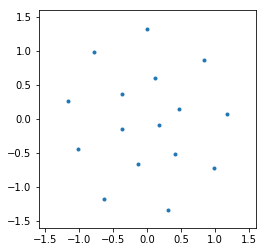

In [15]:
pred_const = sess.run(enc_seed)
plt.plot(pred_const[:,0],pred_const[:,1],'.')
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);